# Python Code by Jehannes 

## Import Libraries 

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import bicgstab, LinearOperator
from scipy.linalg import issymmetric
from time import perf_counter

## Section 1: Read From File and Analyze Matrix 

In [17]:
""" Domenico: define your own path and unzip the matrix from the zip file in my  email  """
verzeichnis=r"MCP1630(kfirstcomp)"   

factor=1.e8

print("Verzeichnis=",verzeichnis)
# Wenn deine CSR-Daten (insbesondere ia und ja) 1-basiert sind (also mit Index 1 statt 0 beginnen, 
# wie z. B. in Fortran oder MATLAB), musst du die Indizes um 1 verringern, bevor du sie in Python/NumPy/Scipy benutzt, 
# denn Python verwendet 0-basierte Indizes.
print("\nCheck ia[0] =", np.loadtxt(os.path.join(verzeichnis, "ja.dat"), dtype=int)[0])

data    = np.loadtxt(os.path.join(verzeichnis, "A.dat")) 
indices = np.loadtxt(os.path.join(verzeichnis, "ja.dat"), dtype=int)- 1  # <-- minus 1
indptr  = np.loadtxt(os.path.join(verzeichnis, "ia.dat"), dtype=int)- 1  # <-- minus 1
b       = np.loadtxt(os.path.join(verzeichnis, "B.dat")) 
b       = b*factor
print ("data0=",data[0])
print ("ja0=",indices[0])
print ("ia0=",indptr[0])
print ("b0=",b[0])

Verzeichnis= MCP1630(kfirstcomp)

Check ia[0] = 1
data0= 14685725.8434757
ja0= 0
ia0= 0
b0= 564753.1090890885


In [18]:
n_rows = len(indptr) - 1
A = sp.csr_matrix((data, indices, indptr), shape=(n_rows, n_rows))
Afull = sp.csr_matrix.todense(A)

In [19]:
issymmetric(Afull)

False

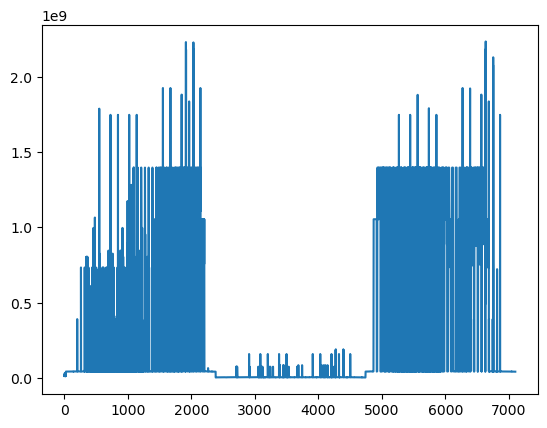

In [32]:
D = np.diag(Afull)
plt.plot(D)

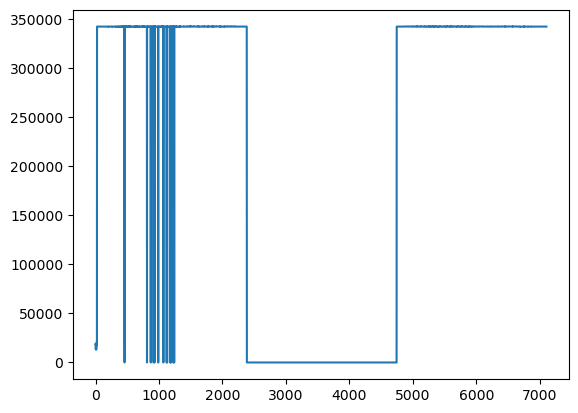

In [36]:
v = np.ones((n_rows,1))
# w = np.matmul(A,v)
w = A @ v # sparse matrix - vector multiplication 
plt.plot(w)

In [11]:
x = np.linalg.solve(Afull, b)

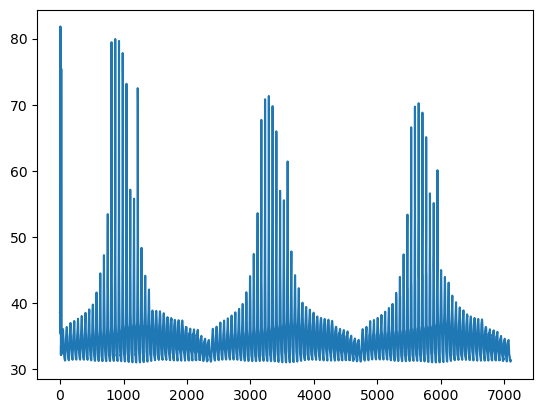

In [12]:
plt.plot(x)

## Original Code of Jehannes 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 17 19:23:49 2025

@author: joe
read own CSR3 Matrix from TRM:     
    SOLVERstencil_to_csr3 
    SOLVERWritePARDISOMatrix
Status 22.04.2025
Status 1.5.25: A,b,ia,ja and n(ijk)info
"""
import os
import pyamg
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from pyamg.relaxation.relaxation import gauss_seidel
from scipy.sparse.linalg import bicgstab, LinearOperator
from time import perf_counter

""" ------------ IMPORT csr file from TRM ---------- """

# Lies die Dateien ein. Das r ermöglicht \ mit escape character
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\Testmatrix(plate)_5mm"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\TestMatrix(plate)_1mm"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\TestMatrix(plate)_0.1mm"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\Testmatrix(plate)_N_of"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\MCP1630(embedded)"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\MCP1630(k=0comp)"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\MCP1630(k=0riters)"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\MCP1630(MOR)"
#verzeichnis=r"D:\ADAM\Projekte\AMG(Delft)\pythonmatrix\MCP1630(kfirstcomp)" 
#verzeichnis=r"D:\TRM\Test3ALL\AMGDelft\Benchmark1"
#verzeichnis=r"D:\TRM\Test3ALL\AMGDelft\Benchmark2"

""" Domenico: define your own path and unzip the matrix from the zip file in my  email  """
verzeichnis=r"MCP1630(kfirstcomp)"   

factor=1.e8

print("Verzeichnis=",verzeichnis)
# Wenn deine CSR-Daten (insbesondere ia und ja) 1-basiert sind (also mit Index 1 statt 0 beginnen, 
# wie z. B. in Fortran oder MATLAB), musst du die Indizes um 1 verringern, bevor du sie in Python/NumPy/Scipy benutzt, 
# denn Python verwendet 0-basierte Indizes.
print("\nCheck ia[0] =", np.loadtxt(os.path.join(verzeichnis, "ja.dat"), dtype=int)[0])

data    = np.loadtxt(os.path.join(verzeichnis, "A.dat")) 
indices = np.loadtxt(os.path.join(verzeichnis, "ja.dat"), dtype=int)- 1  # <-- minus 1
indptr  = np.loadtxt(os.path.join(verzeichnis, "ia.dat"), dtype=int)- 1  # <-- minus 1
b       = np.loadtxt(os.path.join(verzeichnis, "B.dat")) 
b       = b*factor
print ("data0=",data[0])
print ("ja0=",indices[0])
print ("ia0=",indptr[0])
print ("b0=",b[0])

# Optional: sicherstellen, dass arrays korrekt geformt sind
#data = np.asarray(data)
#indices = np.asarray(indices)
#indptr = np.asarray(indptr)

""" ------------ AMG SOLVE ---------- """

# Anzahl Zeilen aus Länge von indptr ableiten
n_rows = len(indptr) - 1
print("len(indices)= ",len(indices))
print("len(indptr)= ",len(indptr))
print("len(b)= ",len(b))

# CSR-Matrix erzeugen

A = sp.csr_matrix((data, indices, indptr), shape=(n_rows, n_rows))    

#--N=500
#--print(N)
#--A = pyamg.gallery.poisson((N,N), format='csr')  # 2D Poisson problem on 500x500 grid
t0 = perf_counter()
print ("pyamg.ruge_stuben_solver")
ml = pyamg.ruge_stuben_solver(A,                   # construct the multigrid hierarchy
#    strength=('classical', {'theta': 0.25}),      # not when 'CR'
#    strength=('algebraic_distance'),
#   strength=( 'symmetric'),                        #schlecht
#    strength=(None),                               #sclecht
#     strength=('evolution'),                        #schlecht
 #   CF=('RS', {'second_pass': False}),             #schlecht
    CF=('CR'),                                      # gut
#    CF=('PMISc'),                                  #schlecht
#   CF=('CLJPc'),                                    #schlecht
#    interpolation='classical',
#    interpolation='direct',
    presmoother=('gauss_seidel', {'sweep': 'symmetric'},1),
    postsmoother=('gauss_seidel', {'sweep': 'symmetric'},1),
#    presmoother = ('richardson', {'omega': 0.2, 'iterations': 10}),
#    postsmoother = ('richardson', {'omega': 0.2, 'iterations': 10}),
    max_levels=3,       
    max_coarse=30,
    coarse_solver='pinv',                           # good:'splu' (def), good:'lu', good:'pinv', 'cholesky'
    keep=False) #default
 #   keep=True)  

# geht nicht print("\npyamg.aggregation.smoothed_aggregation_solver")
# geht nicht ml = pyamg.aggregation.smoothed_aggregation_solver(A)

print("\nHierarchy ")   
print(ml)                                           # print hierarchy information
# erguibt keinen Verbesserung ui[2263]=b[2262]     #TEST
x0 = np.full(len(b),30.)                            # initial values 
x = ml.solve(b, x0=x0, tol=1e-15)                          # solve Ax=b to a tolerance of 1e-10

t1 = perf_counter()
print("residual: ", np.linalg.norm(b-A*x))          # compute norm of residual vector
print("solution: ",x)
print("min: ",min(x))
print("max: ",max(x))
print("Elapsed time:", t1 - t0,"  seconds")

"""======================================================
           ...  PLOT AMG PCB result planes ----
   ======================================================
"""
print("\nStart plot AMG solution ===============================")

umax=np.max(x)
umin=np.min(x)

""" for plotting only . pyinfo** :  3 inter valies to map node numbers to geometric  position vertical level
          59          40     # Nx, Ny number of nodes in x and y. 
21 8 0                       # node integer position in x ,  in y , index of csr3 node
22 8 1
23 8 2
21 14 3
"""

# don't use: dateien = ["n(ijk)info00.dat","n(ijk)info01.dat", "n(ijk)info02.dat", "n(ijk)info03.dat"]  

dateien = ["pyinfo00.dat","pyinfo01.dat", "pyinfo02.dat", "pyinfo03.dat"]  
for dateiname in dateien:
# === 1. Datei einlesen ===
    pfad = os.path.join(verzeichnis, dateiname)
    with open(pfad, "r") as f:
        Nx, Ny = map(int, f.readline().split())
        data = np.loadtxt(f, dtype=int).astype(np.int64)
    
    # === 2. Spalten extrahieren ===
    i_vals = data[:, 0]  # i von 1 bis Nx (Zeilenindex)
    j_vals = data[:, 1]  # j von 1 bis Ny (Spaltenindex)
    n_vals = data[:, 2]  # CSR-Index (beginnend bei 0)
    
    # === 3. Lösung x[n] muss vorhanden sein ===
    # x = ...  # Lösung aus pyamg oder Gauss-Seidel (Länge = Nx * Ny)
    
    # === 4. Umwandeln in Matrix u(i,j) zum Plotten ===
    # Achtung: i, j starten bei 1 → um -1 verschieben für Python-Indexierung
    u = np.full((Nx, Ny), 30.) # initilize with 30 °C
    for idx in range(len(n_vals)):
        i = i_vals[idx] - 1
        j = j_vals[idx] - 1
        n = n_vals[idx] 
        u[i, j] = x[n]
 
    # === 5. Plotten ===   
    # Entlang der x-Achse wird j (die Spalte) von u[i,j] geplottet.
    # man muss u transponieren
    plt.imshow(u.T, origin='lower', cmap='turbo',vmax=umax, vmin=umin ,extent=[1, Nx, 1, Ny])
    plt.colorbar(label="x[i,j]")
    plt.title(verzeichnis+dateiname)
    plt.xlabel("i (x-Achse)")
    plt.ylabel("j (y-Achse)")
    plt.grid(True)
    plt.show()
    
print("\nLine Plot")
n = np.arange(len(x))    # n = 0, 1, 2, ..., len(y)-1
plt.plot(n, x, marker='', linestyle='-')
plt.xlabel("Index n")
plt.ylabel("x(n)")
plt.title("AMG Solution vs n")
plt.grid(True)
plt.show()


plt.plot(n, b, marker='', linestyle='-')
plt.ylim(np.min(b),np.max(b)) 
plt.xlabel("Index n")
plt.ylabel("b(n)")
plt.title("AMG B-vector vs n")
plt.grid(True)
plt.show()
index_max = np.argmax(b)
print("Index des b-Maximums:", index_max)
print("Maximaler b-Wert:", b[index_max])
input("Press Enter to continue with bicgstab...")

print("\nEnd AMG plot")

""" --- Check --------- SOLVE again with bicgstab---------- """

"""
print("\nbicgstab ==== no preconditioning ====================")

            t0 = perf_counter()
            x0 = np.full(len(b),30.)
            
            # Solve Ax = b with BiCGSTAB
            x, info = bicgstab(A, b, x0=x0, rtol=1e-10, maxiter=1000)
            print("max",np.max(x)) 
            print("min",np.min(x)) 
            print("info",info)
            t1 = perf_counter()
            resid = np.linalg.norm(b - A @ x)
            print("\nResiduum ",resid)
            print("\nbicgstab solution: ",x)
            print("Elapsed time:", t1 - t0,"  seconds") 
            
"""

print("\nbicgstab diag^-1 precond ========================")
# Diagonale extrahieren und Inverse berechnen
diagonal = A.diagonal()
inv_diag = 1.0 / diagonal
x0 = np.full(len(b),30.)
t0 = perf_counter()
# Vorkonditionierer-Funktion definieren
def Mx(x):
    return inv_diag * x  # elementweise Multiplikation

# LinearOperator für M
M = LinearOperator(A.shape, matvec=Mx, dtype=A.dtype)

# LinearOperator mit einfacher Lambda-Funktion
#M = LinearOperator(A.shape, matvec=lambda x: inv_diag * x)
x, info = bicgstab(A, b, M=M, x0=x0, rtol=1e-10, maxiter=10000)
t1 = perf_counter()
print("max",np.max(x)) 
print("min",np.min(x)) 
print("info",info)

resid = np.linalg.norm(b - A @ x)
print("\nResiduum ",resid)
print("\nbicgstab solution: ",x)
print("Elapsed time:", t1 - t0,"  seconds") 

print("\nStart plot bicgstab ===============================")

umax=np.max(x)
umin=np.min(x)
# don't use: dateien = ["n(ijk)info00.dat","n(ijk)info01.dat", "n(ijk)info02.dat", "n(ijk)info03.dat"]  
dateien = ["pyinfo00.dat","pyinfo01.dat", "pyinfo02.dat", "pyinfo03.dat"]  
for dateiname in dateien:
# === 1. Datei einlesen ===
    pfad = os.path.join(verzeichnis, dateiname)
    with open(pfad, "r") as f:
        Nx, Ny = map(int, f.readline().split())
        data = np.loadtxt(f, dtype=int).astype(np.int64)
    
    # === 2. Spalten extrahieren ===
    i_vals = data[:, 0]  # i von 1 bis Nx (Zeilenindex)
    j_vals = data[:, 1]  # j von 1 bis Ny (Spaltenindex)
    n_vals = data[:, 2]  # CSR-Index (beginnend bei 0)
    
    # === 3. Lösung x[n] muss vorhanden sein ===
    # x = ...  # Lösung aus pyamg oder Gauss-Seidel (Länge = Nx * Ny)
    
    # === 4. Umwandeln in Matrix u(i,j) zum Plotten ===
    # Achtung: i, j starten bei 1 → um -1 verschieben für Python-Indexierung
    u = np.full((Nx, Ny), 0.) # initilize with 0
    for idx in range(len(n_vals)):
        i = i_vals[idx] - 1
        j = j_vals[idx] - 1
        n = n_vals[idx]
        u[i, j] = x[n]
    
    # === 5. 2D Plotten ===   
    # Entlang der x-Achse wird j (die Spalte) von u[i,j] geplottet.
    # man muss u transponieren
    plt.imshow(u.T, origin='lower', cmap='turbo',vmax=umax, vmin=umin ,extent=[1, Nx, 1, Ny])
    plt.colorbar(label="x[i,j]")
    plt.title(verzeichnis+dateiname)
    plt.xlabel("i (x-Achse)")
    plt.ylabel("j (y-Achse)")
    plt.grid(True)
    plt.show()

print("\nEnd plot")

print("\n1D Line Plot")
n = np.arange(len(x))    # n = 0, 1, 2, ..., len(y)-1
plt.plot(n, x, marker='', linestyle='-')
plt.xlabel("Index n")
plt.ylabel("x(n)")
plt.title("bicgstab Solution vs n")
plt.grid(True)
plt.show()

plt.plot(n, b, marker='', linestyle='-')
plt.ylim(np.min(b),np.max(b)) 
plt.xlabel("Index n")
plt.ylabel("b(n)")
plt.title("AMG B-vector vs n")
plt.grid(True)
plt.show()
index_max = np.argmax(b)
print("Index des b-Maximums:", index_max)
print("Maximaler b-Wert:", b[index_max])

ModuleNotFoundError: No module named 'pyamg'